# Comparison of Fitting Routines and Continuum Model Formulations

Check speed and handling of positivity constraint on decay rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp

import DMdecay as dmd
import JWSTutils as jwst
from gnz11_split import partition_gnz11

# below is needed by the master fiting routine copied below
import copy

import scipy.optimize as opt
import scipy.interpolate as interp

from DMdecay import halo
from nestedtolist import nestedtolist

from DMdecay.linesearch import spline_residual, find_raw_limit

#### Importing data 
Use the data and configuration from arxiv v1

In [2]:
config_filename = "gnz11_split/gnz11_split.toml"

In [3]:
configs = dmd.prep.parse_configs(config_filename)
num_knots = configs["analysis"]["num_knots"]

data = jwst.process_datafiles(configs["run"]["paths"], 
                              configs["system"]["res_path"])
data = partition_gnz11(data, 
                       configs["run"]["lambda_min"],
                       configs["run"]["lambda_split"])
for spec in data:
    dmd.prep.doppler_correction(spec, configs["halo"])
    dmd.prep.add_Dfactor(spec, configs["halo"])
num_specs = len(data)
print(f"Loaded {num_specs} spectra")

parsing gnz11_split/gnz11_split.toml
processing 2 datafiles...
Loaded 2 spectra


#### Generalized fitting code

In the arxiv v1 analysis code, all the steps of a single line search at a given mass are implemented in one function find_raw_limit.  This is imported above for a cross-check.  Here I implement some of the pre-processing done by this function, but generalize it to be able to swap in different continuum models and different optimizers. 

In [4]:

def faster_polyval(p, x):
    """ 
    evaluate a polynomial of coefficients p at x, where p lists the coefficents from larger-power to least
    """
    y = np.zeros(x.shape, dtype=float)
    for i, v in enumerate(p):
        y *= x
        y += v
    return y


def polynomial_residual(knot_values, x, y, sigma_y):
    """ 
    Calculate the residuals for a polynomial fit.  This is to be compared with a spline fit of a fixed number of knots, so here we take that number of knots as the number of polynomial terms so the number of fit params is the same.
    """
    num_specs = len(x)
    num_knots = int(knot_values.size/num_specs)
    resiudal_list = []
    for i in range(num_specs):
        start = i*num_knots
        end = (i + 1)*num_knots
        poly = faster_polyval(knot_values[start:end], x[i])
        resiudal_list.append((y[i] - poly)/sigma_y[i])
    return np.concatenate(resiudal_list)

In [5]:
def compare_continuum_fit(configs, data, lam0, 
                          model="spline"):
    padding = configs["analysis"]["padding"]
    num_knots = configs["analysis"]["num_knots"]
    max_clip_iters = configs["analysis"]["max_clip_iters"]
    clipping_factor = configs["analysis"]["clipping_factor"]
    chisq_step = configs["analysis"]["chisq_step"]
    limit_guess = configs["analysis"]["limit_guess"] 
    window = configs["analysis"]["width_factor"]*configs["halo"]["sigma_v"]
    # extract line search region 
    sky_list = []
    lam_list = []
    raw_error_list = []
    fixed_list = []
    spec_list = []
    res_list = []
    lstart = [spec["lam"][0] for spec in data]
    lend = [spec["lam"][-1] for spec in data]
    lmin = lam0*(1.0 - 0.5*window)
    lmax = lam0*(1.0 + 0.5*window)
    for i, spec in enumerate(data):
        if (lam0 < lstart[i]) or (lam0 > lend[i]):
            continue
        if lmin < lstart[i]:
            l_left = lstart[i]
            l_right = l_left*(1 + window)
        elif lend[i] < lmax:
            l_right = lend[i]
            l_left = l_right*(1 - window)
        else:
            l_left = lmin
            l_right = lmax
        select = (l_left < spec["lam"]) & (spec["lam"] < l_right)
        spec_list.append(i)
        sky_list.append(spec["sky"][select])
        lam_list.append(spec["lam"][select])
        raw_error_list.append(spec["error"][select])
        fixed_list.append([lam0, spec["D"], 
                           halo.sigma_from_fwhm(spec["res"], lam0, 
                                                configs["halo"]["sigma_v"])])    
        res_list.append(spec["res"])
    num_specs = len(sky_list)
    if num_specs == 0:
        return [[lmin, lmax], spec_list, [None], [None], 
                [np.nan, None], [np.nan, None], np.nan, None, 
                None, lam0, None, None, None, None, None, None]

    # fit continuum
    if model == "spline":
        knots = np.zeros(num_specs*num_knots)
        initial_knot_values = np.zeros(num_specs*num_knots)
        for i in range(num_specs):
            start = i*num_knots
            end = (i + 1)*num_knots
            knots[start:end] = np.linspace(lam_list[i][0]*(1 + padding), 
                                        lam_list[i][-1]*(1 - padding), 
                                        num_knots)
            initial_knot_values[start:end] = (
                interp.interp1d(lam_list[i], sky_list[i])(knots[start:end]))
        continuum_fit = opt.least_squares(
            spline_residual, initial_knot_values,
            args=(knots, lam_list, sky_list, raw_error_list))
    if model == "polynomial":
        knots = None
        initial_knot_values = np.zeros(num_specs*num_knots)
        for i in range(num_specs):
            end = (i + 1)*num_knots - 1
            initial_knot_values[end] = np.median(sky_list[i])
        continuum_fit = opt.least_squares(
            polynomial_residual, initial_knot_values,
            args=(lam_list, sky_list, raw_error_list))
    best_knot_values = continuum_fit["x"]
    error_scale_factors = None
    limit_rate = None
    limit_knots = None
    best_rate = None
    delta_chisq = None
    lam_list_msk = None
    error_list_msk = None
    error_list= raw_error_list    
    return [[lmin, lmax], spec_list, knots, error_scale_factors, 
                [limit_rate, limit_knots], [best_rate, best_knot_values],
                delta_chisq, lam_list_msk, error_list_msk, lam0,
                sky_list, lam_list, error_list, fixed_list, 
                spec_list, res_list]

test this 

In [6]:
lam0 = 2.44 # um, used in previous examples 
out_spline = compare_continuum_fit(configs, data, lam0, model="spline")
out_poly = compare_continuum_fit(configs, data, lam0, model="polynomial")

[[lmin, lmax], 
     spec_list, 
     knots, 
     error_scale_factors,
     [limit_rate, limit_knots], 
     [best_rate, best_knots_spline],
     delta_chisq,
     lam_list_msk, 
     error_list_msk, 
     lam0_tmp,
     sky_list, 
     lam_list, 
     error_list, 
     fixed_list, 
     spec_list, 
     res_list] = out_spline
best_coefs_poly = out_poly[5][1]

1
1
1


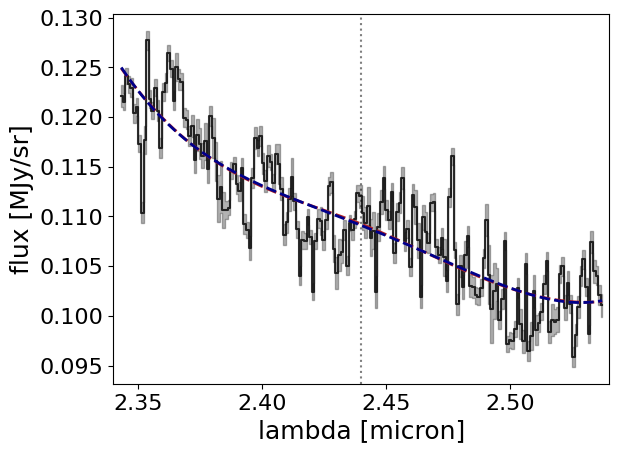

In [7]:
fig, ax = plt.subplots()
print(len(sky_list))
print(len(error_list))
num_fitted_specs = len(knots)//num_knots
print(num_fitted_specs)
for i in range(num_fitted_specs):
    start = i*num_knots
    end = (i + 1)*num_knots
    ax.fill_between(lam_list[i], 
                sky_list[i] - error_list[i], 
                sky_list[i] + error_list[i], step="mid",
                color='black', alpha=0.3)
    ax.step(lam_list[i], sky_list[i], where="mid",
            color='black', alpha=0.8)
    # limiting model 
    continuum_model = interp.CubicSpline(knots[start:end], 
                                         best_knots_spline[start:end])
    poly_model = faster_polyval(best_coefs_poly[start:end], lam_list[i])
    ax.plot(lam_list[i], continuum_model(lam_list[i]), 
            color='firebrick', linestyle='dashed', marker='', 
            linewidth=2, alpha=1)
    ax.plot(lam_list[i], poly_model, 
            color='darkblue', linestyle='dashed', marker='', 
            linewidth=2, alpha=1)
    ax.axvline(lam0, linestyle='dotted', color='black', alpha=0.5)

ax.set_xlim(lam0 - 0.1, lam0 + 0.1)
ax.set_xlabel(r"lambda [micron]", fontsize=18)
ax.set_ylabel(r"flux [MJy/sr]", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

In [9]:
%timeit compare_continuum_fit(configs, data, lam0, model="spline")

8.89 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%timeit compare_continuum_fit(configs, data, lam0, model="polynomial")

22.8 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit faster_polyval(best_coefs_poly[start:end], lam_list[i])

32.7 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%timeit continuum_model(lam_list[i])

23.9 µs ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
